In [3]:
# USANDO REDES NEURONALES 
import numpy as np
%pip install tensorflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import random
import os

  Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached wrapt-1.17.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp312-cp312-macosx_11_0_universal

In [4]:
# REPRODUCIBILIDAD (control básico)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# CARGA (ajusta la ruta si tu dataframe ya está en memoria)
# data = pd.read_excel("inc_final.xlsx")  # o el DataFrame ya cargado
# Supongo que 'data' ya existe en el entorno como en tus pasos previos.

# FEATURES y TARGET (ajusta si tus columnas tienen otro nombre)
features = ['reassignment_count', 'reopen_count', 'sys_mod_count',
            'impact_ord', 'urgency_ord', 'knowledge']  # quitamos know_ord por redundancia
target = 'time_min'

In [5]:
# 1) LIMPIEZA BÁSICA: eliminar filas con target nulo y rellenar/filtrar NaNs en features
data = pd.read_csv('inc_final.csv', index_col=0)
df = data.copy()
df = df[df[target].notna()].reset_index(drop=True)
# Opcional: imputación simple (media) para features numéricas
df[features] = df[features].fillna(df[features].median())

# 2) SPLIT Train/Test (80/20)
X = df[features].astype(float)
y = df[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# 3) ESCALADO (es importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------- BASELINE: Regresión Lineal ---------
lin = LinearRegression()
lin.fit(X_train_scaled, y_train)  # escalamos también para comparar coeficientes relativos
y_pred_lin = lin.predict(X_test_scaled)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("=== Baseline: Regresión Lineal ===")
print("Coeficientes (estandarizados):", dict(zip(features, lin.coef_)))
print(metrics(y_test, y_pred_lin))

=== Baseline: Regresión Lineal ===
Coeficientes (estandarizados): {'reassignment_count': np.float64(-613.1745082900111), 'reopen_count': np.float64(-274.45317225702337), 'sys_mod_count': np.float64(4362.83218007326), 'impact_ord': np.float64(180.80095604570064), 'urgency_ord': np.float64(-115.7124016659364), 'knowledge': np.float64(2462.6309153693087)}
{'MAE': 3316.8874413667468, 'MSE': 24257849.082785863, 'RMSE': np.float64(4925.225790030937), 'R2': 0.4773223820432845}


In [6]:
# MODELO NN: MLP sencillo (una o dos capas ocultas) 
def build_mlp(input_dim, hidden_layers=[64,32], lr=1e-3, l2_reg=0.0, dropout=0.0):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_layers:
        if l2_reg > 0:
            model.add(layers.Dense(units, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        else:
            model.add(layers.Dense(units, activation='relu'))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Puedes usar ReduceLROnPlateau si quieres
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

# Construir y entrenar
input_dim = X_train_scaled.shape[1]
model = build_mlp(input_dim, hidden_layers=[128,64], lr=1e-3, l2_reg=1e-4, dropout=0.1)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)

# Predicción y métricas
y_pred_nn = model.predict(X_test_scaled).ravel()
print("=== Modelo NN (128-64) ===")
print(metrics(y_test, y_pred_nn))

Epoch 1/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 165110816.0000 - mean_absolute_error: 10934.0674 - val_loss: 119158232.0000 - val_mean_absolute_error: 9016.6924 - learning_rate: 0.0010
Epoch 2/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 56655240.0000 - mean_absolute_error: 5572.2739 - val_loss: 29711596.0000 - val_mean_absolute_error: 3540.9858 - learning_rate: 0.0010
Epoch 3/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 25997742.0000 - mean_absolute_error: 3303.5708 - val_loss: 25245820.0000 - val_mean_absolute_error: 3330.5693 - learning_rate: 0.0010
Epoch 4/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 24433134.0000 - mean_absolute_error: 3279.4609 - val_loss: 24390374.0000 - val_mean_absolute_error: 3279.4160 - learning_rate: 0.0010
Epoch 5/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 23912010.0000 - mean_absolute_error: 3235.4707 - val_loss: 24049282.0000 - val_mean_absolute_error: 3229.1165 - learning_rate: 0.0010
Epoch 6/200


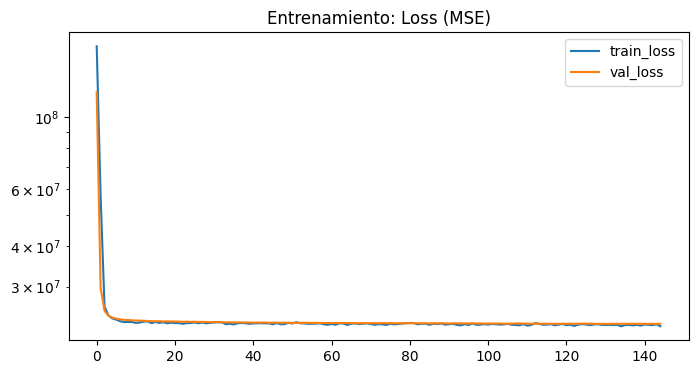

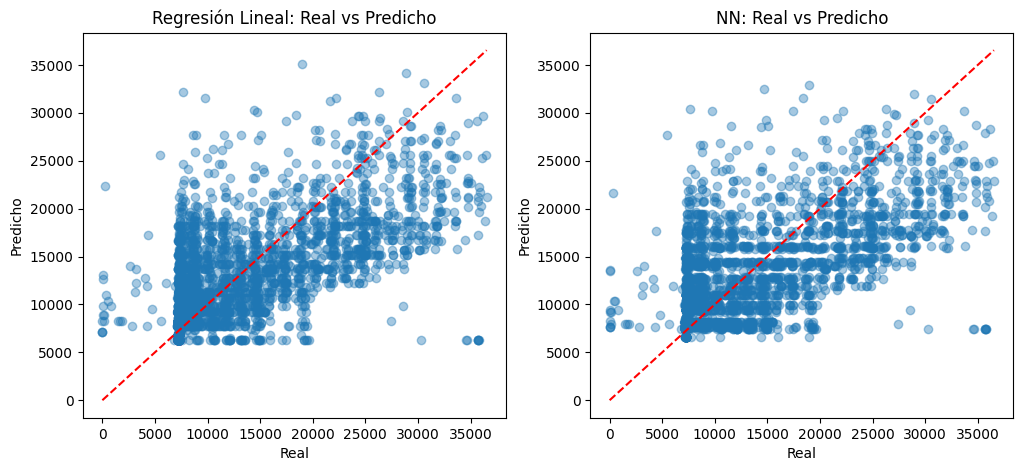

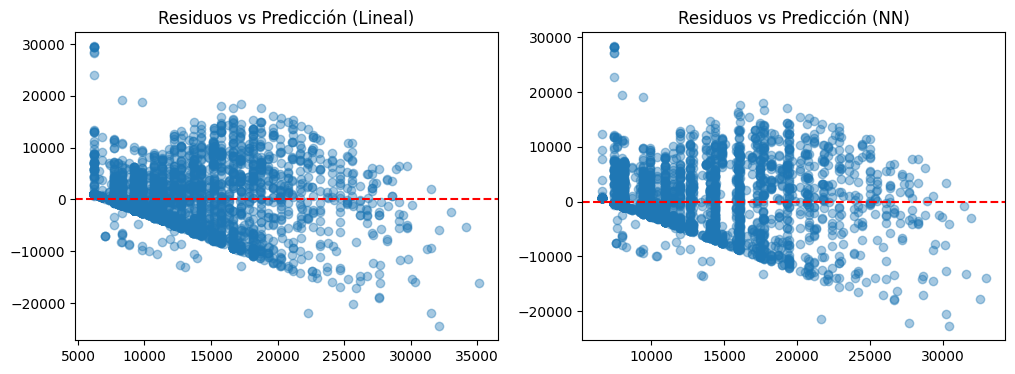

=== Comparación final ===
LINEAR: {'MAE': 3316.8874413667468, 'MSE': 24257849.082785863, 'RMSE': np.float64(4925.225790030937), 'R2': 0.4773223820432845}
NN    : {'MAE': 3139.2991858978976, 'MSE': 23376848.285417803, 'RMSE': np.float64(4834.961042802496), 'R2': 0.4963050790093183}


In [7]:
# GRAFICOS: entrenamiento y residuos 
# 1) Loss durante el entrenamiento
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.title('Entrenamiento: Loss (MSE)')
plt.show()

# 2) Real vs predicho (comparar LN y NN)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lin, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Regresión Lineal: Real vs Predicho')
plt.xlabel('Real'); plt.ylabel('Predicho')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_nn, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('NN: Real vs Predicho')
plt.xlabel('Real'); plt.ylabel('Predicho')
plt.show()

# 3) Residuos
res_lin = y_test - y_pred_lin
res_nn  = y_test - y_pred_nn

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(y_pred_lin, res_lin, alpha=0.4); plt.axhline(0,color='r',linestyle='--')
plt.title('Residuos vs Predicción (Lineal)')
plt.subplot(1,2,2)
plt.scatter(y_pred_nn, res_nn, alpha=0.4); plt.axhline(0,color='r',linestyle='--')
plt.title('Residuos vs Predicción (NN)')
plt.show()

# IMPRESION RESUMEN COMPARATIVO
print("=== Comparación final ===")
print("LINEAR:", metrics(y_test, y_pred_lin))
print("NN    :", metrics(y_test, y_pred_nn))